In [2]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import pandas_datareader as pdr_web

# package for convex optimization
from cvxopt import blas, matrix, solvers

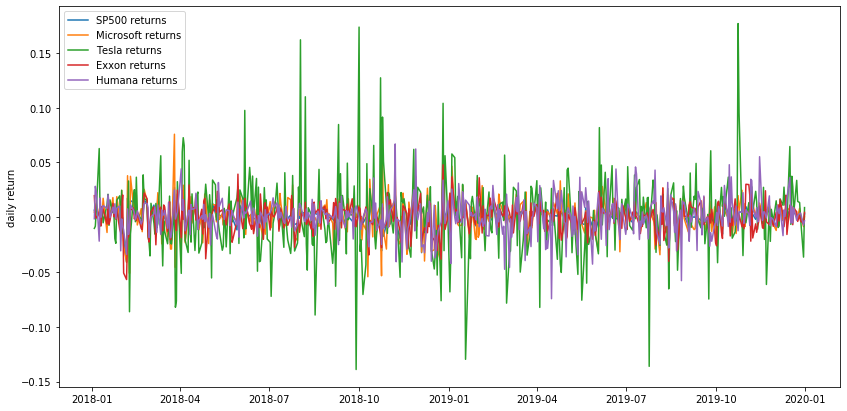

Correlation among the 4 selected stocks:

          MSFT      TSLA       XOM       HUM
MSFT  1.000000  0.350178  0.452756  0.354136
TSLA  0.350178  1.000000  0.245504  0.078119
XOM   0.452756  0.245504  1.000000  0.302485
HUM   0.354136  0.078119  0.302485  1.000000


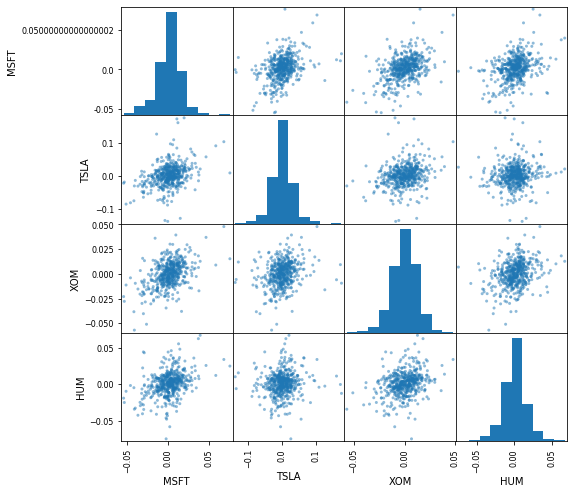

In [3]:
#
# CAPM: find the optimal mean-variance portfolio among 4 stocks,
# minimizing the variance for a target level of expected returns.
#
sp500 = pdr_web.DataReader(name='^GSPC', data_source='yahoo', start='2018-01-01', end='2020-01-01')
microsoft = pdr_web.DataReader(name='MSFT', data_source='yahoo', start='2018-01-01', end='2020-01-01')
tesla = pdr_web.DataReader(name='TSLA', data_source='yahoo', start='2018-01-01', end='2020-01-01')
exxon = pdr_web.DataReader(name='XOM', data_source='yahoo', start='2018-01-01', end='2020-01-01')
humana = pdr_web.DataReader(name='HUM', data_source='yahoo', start='2018-01-01', end='2020-01-01')

# a lambda for calculating net returns.
get_returns_series = lambda df: df['Adj Close'].pct_change().dropna()

sp500_ret = get_returns_series(sp500)
microsoft_ret = get_returns_series(microsoft)
tesla_ret = get_returns_series(tesla)
exxon_ret = get_returns_series(exxon)
humana_ret = get_returns_series(humana)

# Tesla is so much funny compared to other stocks! Coming from different economic sectors, 
# the returns of the 4 stocks are often uncorrelated among themselves.
plt.figure(figsize=(14,7));
plt.ylabel('daily return');
plt.plot(sp500_ret, label='SP500 returns');
plt.plot(microsoft_ret, label='Microsoft returns');
plt.plot(tesla_ret, label='Tesla returns');
plt.plot(exxon_ret, label='Exxon returns');
plt.plot(humana_ret, label='Humana returns');
plt.legend();
plt.show();

# display the correlation matrix among the 4 stocks
stocks_ret_matrix = np.column_stack((microsoft_ret.values, tesla_ret.values, exxon_ret.values, humana_ret.values))
df_stocks_ret = pd.DataFrame(
    index = microsoft_ret.index,
    columns=['MSFT', 'TSLA', 'XOM', 'HUM'],
    data=stocks_ret_matrix
)

pd.plotting.scatter_matrix(df_stocks_ret, figsize=(8, 8));

print('Correlation among the 4 selected stocks:', end='\n\n');
print(df_stocks_ret.corr());


Solve quadratic portfolio optimization problem

Weights for the optimal portfolio: 
[0.28431014 0.01681392 0.42124112 0.27763482]
Weights sum to  1.0
Stocks mean returns: [ 0.00139123  0.00110538 -0.00013888  0.0009109 ]
Mean return of the optimal portfolio: 0.0006085216653012316
Std dev of the optimal portfolio: 0.011046350052449421
.. for the target return:  0.0006076602037646267

********

Weigths of the tangent portfolio [ 1.78978048  0.07798307 -1.50209199  0.63432844]
Std dev and return of the tangent portfolio are respectively: 0.02954402912237351; 0.0033626141651404776
The Sharpe ratio of the optimal portfolio is:  0.11381704747217403


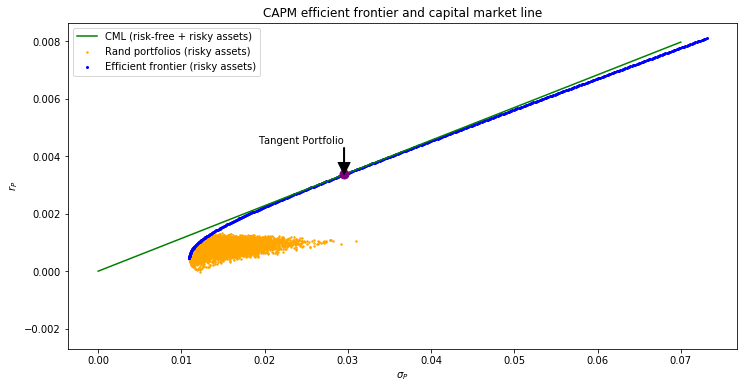

In [157]:
#
# Find the optimal portfolio of these 4 stocks matching the target return and minimizing variance.
# NB: For simplicity we assume a plain zero risk-free rate (reasonable for daily data and in this historical moment)
#
#
# Convex optimization has the general form:
# min(x'*P*x + q'*x)
#
# with the constraints:
# Gx <= h
# Ax = b
#
# in our case 
# x: weigthc
# P: covariance matrix 
# q: zeros matrix
# Gx <= h: translate to return >= target return
# Ax = b: translate to sum(weights) = 1
#
cov_matrix = df_stocks_ret.cov().to_numpy()
assets_mean_returns = df_stocks_ret.mean().values

TARGET_RETURN = 1.5 * sp500_ret.mean() # we want a portfolio gaining 50% more than the market on average!
P = matrix(cov_matrix);
q = matrix(np.zeros((4,1)));
G = matrix(-assets_mean_returns, (1,4), 'd');
h = matrix(-TARGET_RETURN, (1,1), 'd');
A = matrix(np.ones(4), (1,4), 'd');
b = matrix(1, (1,1), 'd');

print('Solve quadratic portfolio optimization problem')
sol = solvers.qp(P, q, G, h, A, b);
optimal_weights = np.array(sol['x']).reshape(len(sol['x'])) # convert cvxopt to np row array

print('\nWeights for the optimal portfolio: \n' + str(optimal_weights))
print('Weights sum to ', sum(optimal_weights))
print('Stocks mean returns:', assets_mean_returns)
print('Mean return of the optimal portfolio:', np.inner(assets_mean_returns, optimal_weights))
print('Std dev of the optimal portfolio:', np.sqrt(optimal_weights.dot(cov_matrix).dot(optimal_weights)))
print('.. for the target return: ', TARGET_RETURN)

#
# Draw the efficient frontier (min-variance portfolio for different target returns)
#
target_returns = np.linspace(start=0.2, stop=20, num=500) * sp500_ret.mean()

def find_optimal_portfolio(tgt_return):
    h = matrix(-tgt_return, (1,1), 'd'); # overwrite just target return
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b);
    opt_weights = np.array(sol['x']).reshape(len(sol['x'])) # convert cvxopt to np row array
    opt_return = np.inner(assets_mean_returns, opt_weights)
    opt_stddev = np.sqrt(opt_weights.T.dot(cov_matrix).dot(opt_weights))
    return opt_stddev, opt_return

ret_risk_points = []
for tgt_ret in target_returns:
    ret_risk_points.append(find_optimal_portfolio(tgt_ret));

# generate some random portfolio of the 4 assets and calculate mean return and variance, to contrast against optimal portfolios
N_RAND_POINTS = 10000
rnd_vecs = np.split(np.random.uniform(size=4 * N_RAND_POINTS), N_RAND_POINTS);

def get_risk_return(rand_vec):
    rnd_weights = rand_vec / sum(rand_vec);
    rnd_return = np.inner(assets_mean_returns, rnd_weights)
    rnd_stddev = np.sqrt(rnd_weights.T.dot(cov_matrix).dot(rnd_weights))
    return rnd_stddev, rnd_return

rand_stddevs, rand_returns = zip(*[get_risk_return(rnd_v) for rnd_v in rnd_vecs]);

# 
# TANGENT PORTFOLIO
# find the weights for the tangent portfolio, that when mixed with the risk-free asset provides the optimal portfolios
#
excess_returns = assets_mean_returns
inv_cov_matrix = np.linalg.inv(cov_matrix)
# TODO: Check the validity of this general formula!!
tang_weights = (1 / (np.ones((1,4)).dot(inv_cov_matrix).dot(excess_returns.T))) * inv_cov_matrix.dot(excess_returns.T)
print('\n********\n')
print('Weigths of the tangent portfolio', tang_weights)
ret_tang_portfolio = tang_weights.dot(excess_returns)
stddev_tang_portfolio = np.sqrt(tang_weights.dot(cov_matrix).dot(tang_weights))
print("Std dev and return of the tangent portfolio are respectively: {0}; {1}".format(stddev_tang_portfolio, ret_tang_portfolio))
sharpe_ratio = ret_tang_portfolio / stddev_tang_portfolio; # slope of the Capital Market Line (CML)
print('The Sharpe ratio of the optimal portfolio is: ', sharpe_ratio)

# plot everything together
x, y = zip(*ret_risk_points)
plt.figure(figsize=(12,6));
#plt.xlim(0.0, 0.04)
#plt.ylim(-0.002, 0.005);
plt.scatter(rand_stddevs, rand_returns, c='orange',s=2, label='Rand portfolios (risky assets)');
plt.scatter(x, y, c='blue', s=4, label='Efficient frontier (risky assets)');

# capital market line
x_stddev = np.linspace(start=0.0, stop=0.07, num=100)
y_cml_ret = sharpe_ratio * x_stddev
plt.plot(x_stddev, y_cml_ret, c='green', label='CML (risk-free + risky assets)')

# mark the tangent porfolio
plt.plot(stddev_tang_portfolio, ret_tang_portfolio, 'o', c='purple', markersize=9)
plt.annotate("Tangent Portfolio",
             xy=(stddev_tang_portfolio, ret_tang_portfolio),
             xytext=(stddev_tang_portfolio, ret_tang_portfolio + 0.001),
             verticalalignment='bottom',
             horizontalalignment='right',
             arrowprops=dict(facecolor='black', width=1))

plt.title('CAPM efficient frontier and capital market line')
plt.xlabel(r'$\sigma_P$');
plt.ylabel(r'$r_P$');
plt.legend();
plt.show();


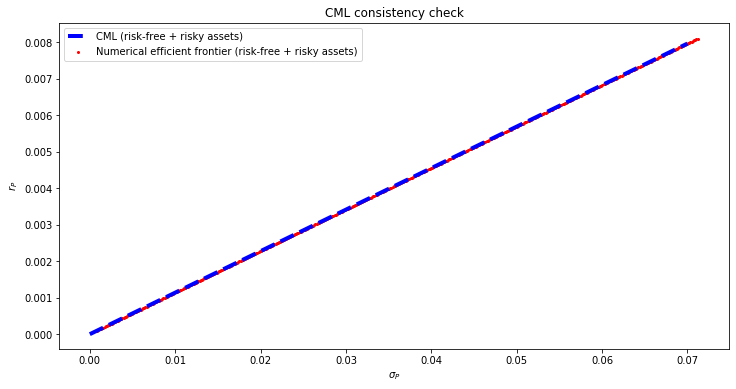

Ok, the theoretical CML matches exactly the frontier found by convex optimization of a portfolio composed by both risk-free and risky assets!!


In [133]:
#
# Just for a consistency check, find and draw the capital market line, passing through the tangent portfolio
# through the convex optimization process: add the risk-free asset as fifth assets and find the new optimal portfolio.
# The optimal portfolio frontier traced numerically should exactly match the CML drawn previously.
#
# the USD risk free rate is estimated as the 1-Month FED treasury yield
# https://www.bloomberg.com/markets/rates-bonds/government-bonds/us
rf_usd = 0.0 #0.001 / 252; # 0.1% per year, expressed on daily basis

# The optimization problem is similar to the one tackled above
# Some transformation in the problem are required, e.g. replace returns with "excess returns" over the risk free rate
# NB assets are now 5: 4 stocks  + 1 risk-free asset
assets_mean_returns = np.append(rf_usd, df_stocks_ret.mean().values - rf_usd)
assets_cov_matrix = np.zeros((5,5))
assets_cov_matrix[1:, 1:] = df_stocks_ret.cov().to_numpy()

P = matrix(assets_cov_matrix);
q = matrix(np.zeros((5,1)));
G = matrix(-assets_mean_returns, (1,5), 'd');
A = matrix(np.ones(5), (1,5), 'd');
b = matrix(1, (1,1), 'd');

# Target return -> TO BE OVERRIDEN
h = matrix(-1.0, (1,1), 'd');

target_returns = np.linspace(start=0.2, stop=20, num=500) * sp500_ret.mean()

def find_optimal_portfolio(tgt_return):
    h = matrix(-tgt_return, (1,1), 'd'); # overwrite just target return
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b);
    opt_weights = np.array(sol['x']).reshape(len(sol['x'])) # convert cvxopt to np row array
    opt_return = np.inner(assets_mean_returns, opt_weights)
    opt_stddev = np.sqrt(opt_weights.T.dot(assets_cov_matrix).dot(opt_weights))
    return opt_stddev, opt_return

ret_risk_points = []
for tgt_ret in target_returns:
    ret_risk_points.append(find_optimal_portfolio(tgt_ret));

# plot everything together
x, y = zip(*ret_risk_points)
plt.figure(figsize=(12,6));

# theoretical capital market line
sharpe_ratio = ret_tang_portfolio / stddev_tang_portfolio; # slope of CML
x_stddev = np.linspace(start=0.0, stop=0.07, num=100)
y_cml_ret = sharpe_ratio * x_stddev
plt.plot(x_stddev, y_cml_ret, c='blue',lw=4, linestyle='--', label='CML (risk-free + risky assets)')

plt.scatter(x, y, c='red', s=4, label='Numerical efficient frontier (risk-free + risky assets)');
plt.title('CML consistency check')
plt.xlabel(r'$\sigma_P$');
plt.ylabel(r'$r_P$');
plt.legend();
plt.show();

print('Ok, the theoretical CML matches exactly the frontier found by convex optimization '
      'of a portfolio composed by both risk-free and risky assets!!')